<h1> ¿Quien Habla? </h1>

<p> El presente proyecto identifica en de un set de datos si quien esta hablando es un politico o un medico. el objetivo es hacer esta clasificación BINARIA por medio de modelos ML. <p>
<li> NLTK: biblioteca de Python ampliamente utilizada en el procesamiento del lenguaje natural (PLN) y la lingüística computacional. Ofrece herramientas para tokenización, segmentación, etiquetado, análisis y procesamiento de texto en varios idiomas. </li>
<li> UNICODE: se utiliza para transformar texto Unicode (que incluye caracteres acentuados y caracteres especiales) en texto ASCII simple y legible.</li>

In [20]:
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode

In [6]:
dialogs = pd.read_csv('C:/Users/chech/PC Febrero 2023/1. Data Scients/Machine Learning Projects/QuienHabla/data/dialogos.csv')
dialogs.sample(5)

,Unnamed: 0,speaker,dialog,length
150734,150734,lopez-gatell,Informamos de algunos avances importantes. El ...,290
67928,67928,amlo,"Entonces, hay una carta de Porfirio que es gen...",248
14584,14584,lopez-gatell,"Por lo que se ve aquí, el porcentaje de activo...",334
71659,71659,amlo,¡Que viva Tepexi!,17
150212,150212,lopez-gatell,Lo importante es que ya llevamos 415 mil 417 v...,63


In [7]:
#Transformación de datos, cambiar la palabra "amlo" por "politico". Lo que no sea amlo dejarlo como "medico"
dialogs["speaker"] = np.where(dialogs['speaker'] == "amlo", "politico", "medico")
dialogs.sample(6)

,Unnamed: 0,speaker,dialog,length
93438,93438,politico,"No, no se modifica ninguna ley. Fue un acuerdo...",220
128477,128477,politico,Esta es la inflación anualizada.,32
80524,80524,politico,Esa era una de las reglas de la anterior polít...,143
32832,32832,medico,"Entonces, hay que quitarnos ya esta idea de: ‘...",130
102252,102252,politico,"Pero no sólo es darle la planta, porque eso no...",406
123089,123089,politico,Muy bien. Reyna.,16


<P> Metrica para el caso de estudio: ACCURACY. <p>
<h1> EDA </h1>

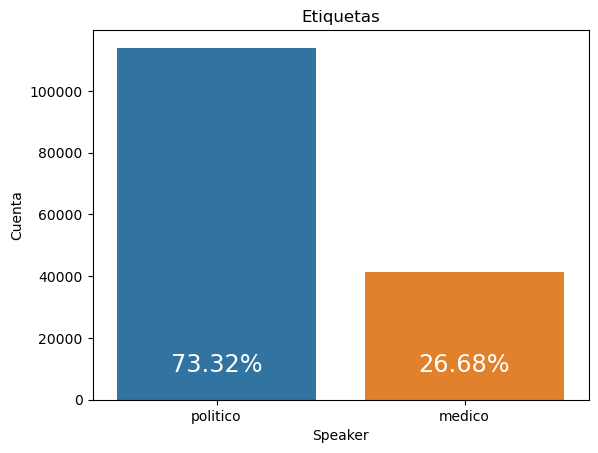

In [10]:
fig = plt.figure(dpi=100)
ax = fig.gca()
sns.countplot(x='speaker', data=dialogs, ax=ax)
ax.set_title('Etiquetas')
ax.set_xlabel('Speaker')
ax.set_ylabel('Cuenta')

percentages = (dialogs["speaker"].value_counts()/len(dialogs)).to_dict()
xs = {label.get_text():idx for idx, label in enumerate(ax.get_xticklabels())}
for label, pct in percentages.items():
    ax.text(xs[label], 9000, f"{pct:0.2%}", ha="center", fontsize='xx-large', c="white")
    pass

# Si bien la diferencia entre las dos categorias es notoria, no hablamos de un dataset desbalanceado. 

<h3> Analisis: Longitud del texto</h3>

<Axes: xlabel='length', ylabel='speaker'>

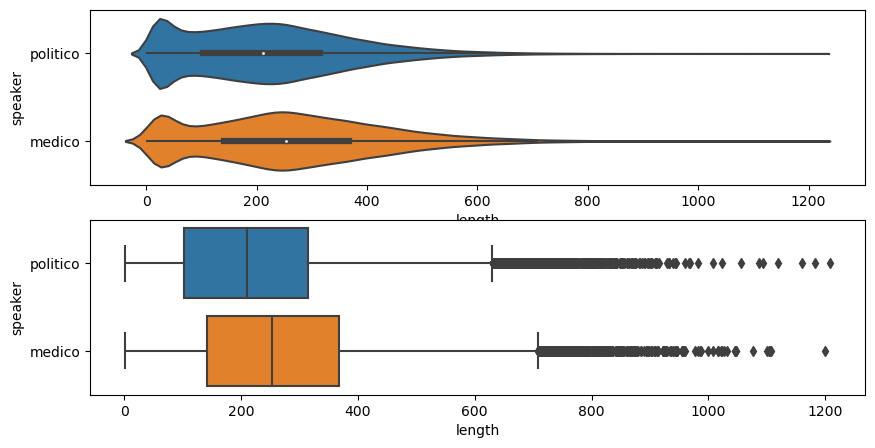

In [12]:
#Analizando la distribución del set de datos.
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=100, figsize=(10, 5))

sns.violinplot(y="speaker", x="length", data=dialogs, ax=ax1)
sns.boxplot(y="speaker", x="length", data=dialogs, ax=ax2)

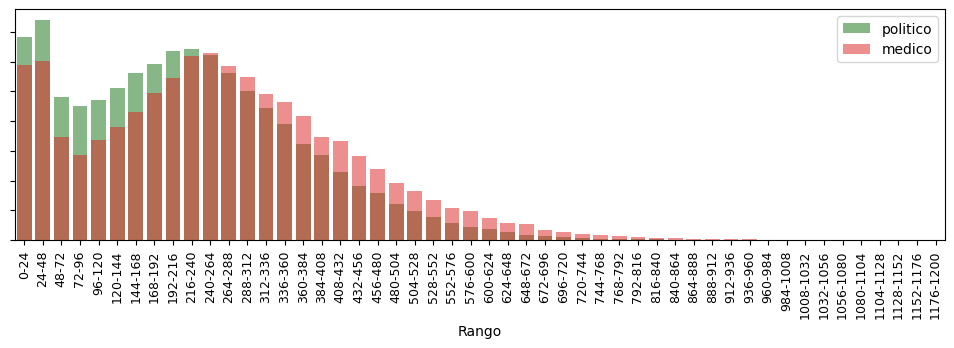

In [17]:
fig = plt.figure(dpi=100, figsize=(12, 3))
ax = fig.gca()

for label, color in [("politico", "green"), ("medico", "red")]:
    lengths = dialogs[dialogs["speaker"] == label]
    values, bins = np.histogram(lengths["length"], range=(0, 1200), bins=50)
    y = (bins[1:] + bins[:-1]) / 2
    sns.barplot(x=y, y=values/ len(lengths), label=label, color=color, ax=ax, alpha=0.5)
ax.set_xticklabels([f"{int(_y)}-{int(_x)}" for _x,_y in zip(bins[1:], bins[:-1])], rotation=90, fontsize=9)
ax.set_yticklabels([])
ax.set_xlabel("Rango")
ax.legend()

<h3> Divición del dataset </h3>
<p> Con "stratify=dialogs["speaker"]" el programa nos hace la distribución 80/20 de namera homogenea y de esta manera evitamos caer en errores de sesgos al momento de partir los datos.</p>

In [21]:
from sklearn.model_selection import train_test_split

In [23]:
rest, test = train_test_split(dialogs, test_size=0.2, stratify=dialogs["speaker"], random_state=40)
train, val = train_test_split(rest, test_size=0.2, stratify=rest["speaker"])
len(train), len(val), len(test)

(99524, 24881, 31102)

In [25]:
# Varialbes con los datos segmentados. 
dialogs_train = train["dialog"]
dialogs_val = val["dialog"]
dialogs_test = test["dialog"]

target_train = train["speaker"] 
target_val = val["speaker"]
target_test = test["speaker"]

<h2> Feature Engineering </h2>
<h2> Etiqueta </h2>
<p> Es necesario transformar nuestro target a valores numericos para que el modelo pueda realizar el proceso
<p> En NumPy, la función numpy.where es una función muy versátil que proporciona una forma eficiente de aplicar una condición y seleccionar elementos de dos arrays (o valores) según esa condición.

In [28]:
# Si es politico poner 1, si es otra cosa 0
train_y = np.where(target_train == "politico", 1, 0)
val_y = np.where(target_val == "politico", 1, 0)
test_y = np.where(target_test == "politico", 1, 0)

In [29]:
target_train

146005      medico
12444     politico
52895     politico
123906    politico
142116    politico
            ...   
73794     politico
33052     politico
93958     politico
94409     politico
104206    politico
Name: speaker, Length: 99524, dtype: object

In [30]:
train_y

array([0, 1, 1, ..., 1, 1, 1])

<h2> Texto </h2>
<p> El desafio importante esta en transformar la cadena de texto a valores que puedan ser procesados por el algoritmo

In [31]:
dialogs_train

146005    Muchas gracias. Son las 20:01. Aquí terminamos...
12444             ¿Qué puedo decirle a la gente, al pueblo?
52895     Celebro que hayan cambiado de parecer los sena...
123906    Si no, pues que decida la cámara, pero yo le t...
142116    Nos da mucho gusto estar de nuevo en las Islas...
                                ...                        
73794     Y buscando que no se explote a los niños, tene...
33052     Y depende mucho de la capacidad productiva de ...
93958                  Ahí se los encargo mucho. Un abrazo.
94409     Y lo otro que ayuda mucho para que no haya aum...
104206    Hoy, en efecto, le decía: Aquí te traigo unos ...
Name: dialog, Length: 99524, dtype: object

In [32]:
example_sentence = dialogs_train.iloc[80567]
print(example_sentence)

Ese es el contexto, esta es la parte positiva de las medidas de seguridad sanitaria, la Jornada Nacional de Sana Distancia.


<h2> Tokenización </h2> 
<p> En una cadena de texto usualmente se tienen elementos como: </p>
<li> Simbolos de puntuación
<li> StopWords
<li> Acentos (Tildes)

In [33]:
from nltk.tokenize.toktok import ToktokTokenizer

tk_tokenizer = ToktokTokenizer()

In [34]:
tokens = tk_tokenizer.tokenize(example_sentence)
print(type(tokens))
print("#".join(tokens))

<class 'list'>
Ese#es#el#contexto#,#esta#es#la#parte#positiva#de#las#medidas#de#seguridad#sanitaria#,#la#Jornada#Nacional#de#Sana#Distancia#.


In [53]:
# Con estos objetos, identifico las cadenas que quiero eliminar para el analisis del texto.
from nltk.corpus import stopwords
sp_stopwords = stopwords.words("spanish")
sp_punctuation = string.punctuation + '¿¡' # Desúes del "+" le puedo agregar manualmente los que no trae string por defecto.

# Vamos a unificar en una sola variable los caracteres no deseados.
not_deseados = set((unidecode(word) for word in sp_stopwords)) | set(sp_punctuation)
not_deseados

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eramos',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estabamos',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estais',
 'estamos',
 'estan',
 'estando',
 'estar',
 'estara',
 'estaran',
 'estaras',
 'estare',
 'estareis',
 'estaremos',
 'estaria',
 'estariais',
 'estariamos',
 'estarian',
 'estarias',
 'estas',
 'este',
 'esteis',
 'estemos',
 'esten',
 'estes',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieramos',
 'estuvieran',
 'estuvieras',
 'estu

In [54]:
# Función que recibe oración 
tk_tokenizer= ToktokTokenizer()

def tokenise(sentence):
    limpia = []
    clean_sentence = unidecode(sentence)
    for token_ in tk_tokenizer.tokenize(clean_sentence):
        token = token_.lower()
        if token in not_deseados:
            continue
        limpia.append(token)
    return limpia    

In [56]:
# Ahora tengo la información pero sin los caracteres no deseados. 
print(tokenise(example_sentence))

['contexto', 'parte', 'positiva', 'medidas', 'seguridad', 'sanitaria', 'jornada', 'nacional', 'sana', 'distancia']


<h2> Vectorización</h2>
<p> Pasar de palabras a numeros, se hacen vectores que representen el texto. 
<h3> One Hot Encoding</h3>
<p> Pone 1 donde coincida.

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizador_ejemplo = CountVectorizer(binary=True, analyzer=tokenise)

In [62]:
ejemplos = [
    "viva mexico paisanos en septiembre",
    "en mexico hay inundaciones de viva voz"
]
vectors = vectorizador_ejemplo.fit_transform(ejemplos)

vocabulary = vectorizador_ejemplo.vocabulary_
columns = [token for token, _ in sorted(vocabulary.items(), key=lambda item: item[1])]
pd.DataFrame(vectors.todense(), columns=columns, index=[1, 2])

,inundaciones,mexico,paisanos,septiembre,viva,voz
1,0,1,1,1,1,0
2,1,1,0,0,1,1


<h2> Convertir los textos a vectores</h2>

In [63]:
vectorizador_real = CountVectorizer(binary=True, analyzer=tokenise, max_features=1000)

In [64]:
# Entrenamiento del modelo.
vectorizador_real.fit(dialogs_train)

CountVectorizer(analyzer=<function tokenise at 0x000001AA690D94E0>, binary=True,
                max_features=1000)

In [65]:
train_x = vectorizador_real.transform(dialogs_train)
val_x = vectorizador_real.transform(dialogs_val)
test_x = vectorizador_real.transform(dialogs_test)

In [66]:
# Esta es una matrix de mil columna con valores 1 y 0
test_x

<31102x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 291397 stored elements in Compressed Sparse Row format>

<h1> Modelado </h1>
<h3> Logistic Regression </h3>

In [67]:
train_x.shape

(99524, 1000)

In [68]:
train_y.shape

(99524,)

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
lr = LogisticRegression()

lr.fit(train_x, train_y)

c:\Users\chech\anaconda3\envs\proyectoCoder\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [71]:
train_pred = lr.predict(train_x) # Para diagnosticar overfitting
val_pred = lr.predict(val_x) # Para predecir cambios sobre el modelo

In [72]:
val_pred

array([1, 1, 1, ..., 1, 1, 1])

In [74]:
from sklearn.metrics import accuracy_score, classification_report

In [75]:
print(classification_report(train_y, train_pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     26552
           1       0.94      0.97      0.96     72972

    accuracy                           0.94     99524
   macro avg       0.93      0.91      0.92     99524
weighted avg       0.94      0.94      0.94     99524



In [78]:
#Accuracy
#Ocurre overfitting cuando el score de entrenamiento es mucho más algo que en validación.
print(accuracy_score(train_y, train_pred))

0.9376029902335116


In [79]:
# Para validar Overfitting - Validación.
print(accuracy_score(val_pred, val_y))

0.9339656766207146


In [81]:
# Para mirar el diccionario de palabras del modelo.
vectorizador_real.vocabulary_

{'muchas': 615,
 'gracias.': 418,
 '20': 12,
 'aqui': 89,
 'semana': 871,
 '21': 15,
 'ano': 80,
 '19': 11,
 'reduccion': 819,
 'epidemia': 344,
 'cada': 132,
 'vez': 983,
 'proceso': 761,
 'vacunacion': 963,
 '?que': 33,
 'puedo': 792,
 'gente': 410,
 'pueblo': 785,
 'diputados': 286,
 'ahora': 62,
 'pesar': 706,
 'madero': 547,
 'final': 388,
 'solo': 900,
 'mayoria': 569,
 'repito': 828,
 'social': 896,
 'pues': 793,
 'decir': 248,
 'siempre': 883,
 'digo': 280,
 'modo': 608,
 'reforma': 821,
 '...': 1,
 'da': 234,
 'gusto': 428,
 'nuevo': 649,
 'darle': 240,
 'proyecto': 776,
 'decision': 250,
 'centro': 154,
 'educativo': 309,
 'entonces': 340,
 'hoy': 462,
 'varios': 969,
 'evidencia': 366,
 'cientifica': 160,
 'vacunas': 965,
 'covid': 214,
 'elementos': 319,
 'van': 967,
 'precisamente': 738,
 'organizacion': 664,
 'mundial': 621,
 'salud': 852,
 'revolucion': 841,
 'partido': 682,
 'unico': 951,
 'tiempo': 924,
 'luego': 543,
 'iba': 465,
 'haber': 429,
 'democracia': 259,
 'm

<h2> Test dataset </h2>
<p> La metrica del modelo realmente se mide con el set de datos de TEST

In [82]:
#Analizar modelo en conjunto de datos de prueba.
test_pred = lr.predict(test_x)
test_accuracy = accuracy_score(test_y, test_pred)

print(f"Test accuracy: {test_accuracy:0.2%}")

Test accuracy: 93.64%


<h3> Pequeña prueba del modelo </h3>

In [89]:
#oracion = "Quedate en casa, la curva de la epidemia no se ha reducido"
#oracion = "Lucharemos por el cambio que nuestro país necesita"
oracion = "¿Tienes alguna alergia a medicamentos o condiciones médicas que debería saber?"

own_x = vectorizador_real.transform([oracion])

result = lr.predict(own_x)
result

array([0])

In [90]:
medico, politico = lr.predict_proba(own_x).squeeze()*100
medico, politico

(81.93684277094607, 18.063157229053928)